# PRUEBA TÉCNICA IFOOD COLOMBIA

Hola Julian, 

Para ser evaluado por el equipo de Data de iFood Colombia, te pedimos que desarrolles el siguiente test con el fin de evidenciar tus habilidades como Data Scientist y tu desempeño resolviendo una tarea común en ciencia de datos.

Este dataset representa 10 años (1999-2008) de atención clínica en 130 hospitales y redes integradas de prestación de servicios de EE. UU. Incluye más de 50 funciones que representan los resultados del paciente y del hospital. Se extrajo información de la base de datos para los ingresos que cumplieron con los siguientes criterios.

(1) Es un ingreso hospitalario (una admisión hospitalaria).

(2) Es un ingreso diabético, es decir, durante el cual se ingresó al sistema cualquier tipo de diabetes como diagnóstico.

(3) La duración de la estancia fue de al menos 1 día y como máximo 14 días.

(4) Se realizaron pruebas de laboratorio durante la estancia.

(5) Se administraron medicamentos durante la estancia.

Los datos contienen atributos tales como número de paciente, raza, sexo, edad, tipo de admisión, tiempo en el hospital, especialidad médica del médico que lo admite, número de pruebas de laboratorio realizadas, resultado de la prueba de HbA1c, diagnóstico, cantidad de medicación, medicamentos para diabéticos, cantidad de pacientes ambulatorios , visitas hospitalarias y urgentes en el año anterior a la hospitalización, etc. Para cada registro existe uno de los siguientes resultados:

* No readmisión;
* Readmisión en menos de 30 días (esta situación no es buena, porque existe la posibilidad de que el tratamiento aplicado no fue apropiado);
* Readmisión después de 30 días (esta situación tampoco es buena, sin embargo, la razón podría estar relacionada con el estado del paciente).

Para tu tarea puedes escoger entre clasificar el resultado de un paciente o clusterizarlos para encontrar patrones que puedan darnos diferentes insights. Te recomendamos que crees un notebook, como Jupyter(si usas python) o Rmarkdown report (si usas R) y lo compartas con nosotros a través de un link de github. 

Tip para el éxito en esta tarea: Define claramente el procedimiento (paso a paso que debe quedar en el notebook en celdas tipo Markdown) que vas a ejecutar sobre el dataset y resalta los aspectos más importantes sobre los cuales consideres que podemos discutir. 

Tienes un día para desarrollar este ejercicio.

Plazo maximo para entrega: Viernes 6:00 pm

Adicional ten en cuenta hacer una presentación de power point con los hallazgos del caso y recomendaciones para el mismo.

¡Éxitos!

## PREPARACIÓN INICIAL
### Importar librerías

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats
from pingouin import pairwise_ttests

### Cargar datos

In [2]:
# Cargar tabla principal
df = pd.read_csv("diabetic_data.csv")

# Cargar mapeo de códigos para las columnas admission_type, discharge_disposition y admission_source
df_id_adm_type = pd.read_csv("IDs_mapping.csv", skiprows=0, nrows=8).rename(columns={"description": "admission_type"}).fillna("Unknown")
df_id_dis_disp = pd.read_csv("IDs_mapping.csv", skiprows=10, nrows=30).rename(columns={"description": "discharge_disposition"}).fillna("Unknown")
df_id_adm_sour = pd.read_csv("IDs_mapping.csv", skiprows=42, nrows=27).rename(columns={"description": "admission_source"}).fillna("Unknown")

### Crear algunas funciones básicas:
Test de chi cuadrado:

In [3]:
def chi2_test(df, var_1, var_2):
    crosstab = pd.crosstab(df[var_1], df[var_2])
    result = stats.chi2_contingency(crosstab)
    print("1. crosstab:")
    print(crosstab)
    print("2. chi squared:", result[0])
    print("3. p-value:", result[1])
    print("4. degrees of freedom:", result[2])
    return result

## ENTENDIMIENTO DE NEGOCIO
Se realizó una búsqueda exhaustiva de las variables que componen el conjunto de datos (diccionario de datos), no sólo para tener un entendimiento más profundo de las mismas, sino porque además a simple vista algunos de los nombres no son intuitivos y o son bastante específicos para el área de estudio.

* 'encounter_id' unique identifier of an encounter
* 'patient_nbr' unique identifier of a patient
* 'race' patient race
* 'gender' patient gender
* 'age' patient aged (binned in intervals of 10 years)
* 'weight' weight in pounds
* 'admission_type_id' type of admission in the hospital
* 'discharge_disposition_id' reason for discharge
* 'admission_source_id' source of admission
* 'time_in_hospital' number of days between admission and discharge
* 'payer_code' identifier for type of insurance/payment
* 'medical_specialty' specialty of the admitting physician
* 'num_lab_procedures' number of lab tested performed during encounter
* 'num_procedures' number of procedures (other than lab tests) during encounter
* 'num_medications' number of distinct medications administered during the encounter
* 'number_outpatient' number of outpatient visits on the year preceding the encounter
* 'number_emergency' number of emergency visits in the year preceding the encouunter
* 'number_inpatient' number of inpatient visits in the year preceding the encounter
* 'diag_1' primary diagnosis
* 'diag_2' secondary diagnosis
* 'diag_3' additional secondary diagnosis
* 'number_diagnoses' number of diagnoses entered in the system
* 'max_glu_serum' glucose serum test result
* 'A1Cresult'  A1c test result

The following 24 features indicate changes in dosage of 24 distinct medications:
* 'metformin'
* 'repaglinide'
* 'nateglinide'
* 'chlorpropamide'
* 'glimepiride'
* 'acetohexamide'
* 'glipizide'
* 'glyburide'
* 'tolbutamide'
* 'pioglitazone'
* 'rosiglitazone'
* 'acarbose'
* 'miglitol'
* 'troglitazone'
* 'tolazamide'
* 'examide'
* 'citoglipton'
* 'insulin'
* 'glyburide-metformin'
* 'glipizide-metformin'
* 'glimepiride-pioglitazone'
* 'metformin-rosiglitazone'
* 'metformin-pioglitazone'
* 'change'  if there was change in the patient's diabetes medication


* 'diabetesMed' if diabetes medication was prescribed
* 'readmitted' the target variable: either "NO", "<30" or ">30"

## EXPLORACIÓN DE DATOS
En esta sección se realizará una compresión inicial del conjunto de datos, las relaciones existentes entre las variables, y problemas de calidad que pudieran encontrarse.

Se cuenta con un conjunto de datos de cerca de 101766 observaciones y 50 variables, la gran mayoría de ellas de tipo categórico por lo que es posible que la dimensionalidad de los modelos sea mucho mayor, y sea necesario transformar las mismas en variables de tipo dummy.

In [4]:
print(df.shape)
df.head()

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Observamos la matrix de correlaciones entre las variables númericas independientes, y se observa que el número de medicamentos, procedimientos y diagnósticos están correlacionados positivamente, es decir variables relacionadas con tratamiento, y de igual manera el número de consultas hospitalarias y de emergencia, o variables relacionadas con número de visitas al hospital.

<AxesSubplot:>

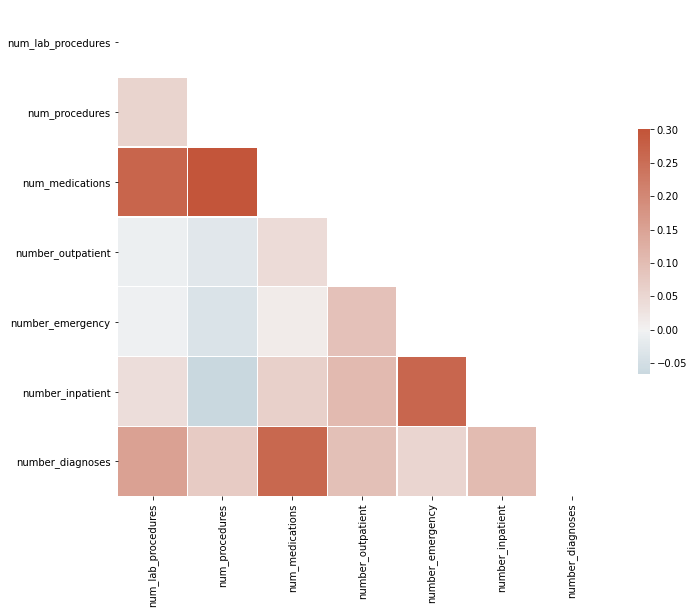

In [5]:
df_temp = df[[
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    "number_diagnoses"
]].copy()

corr = df_temp.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Readmisión
Observamos la distribución de datos en las categorías de la variable objetivo readmisión y nos damos cuenta que cerca del 53% de los pacientes no necesitaron reingreso, un 34% tuvo readmisión superior a 30 días y sólo un 11% readmisión temprana. No se observa un desbalance demasiado grande entre las clases por lo que no se considera necesario realizar algún tipo procedimiento de balanceo de la información.

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64


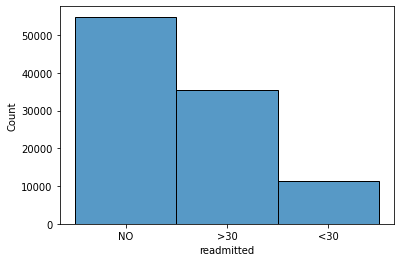

In [6]:
sns.histplot(data=df, x="readmitted")
print(df["readmitted"].value_counts(normalize=True))

### Peso
Si bien la variable de peso está intimamente relacionada con el sufrimiento de diabetes, se observa que la cantidad de datos nulos (?) de la columna es demasiado alta cercana al 96%, por lo que de toma la decisión de descartar esta variable de los análisis.

In [7]:
df["weight"].value_counts(normalize=True)

?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: weight, dtype: float64

### Raza
Se encuentran algunos valores nulos representados por el signo ? en una proporción muy baja y podría pensarse en realizar imputación de los mismos o incluso tomarlos como una categoría adicional. Como es esperado en la población de EEUU, se observa predominancia de población caucásica y afroamericana.

<AxesSubplot:xlabel='race', ylabel='Count'>

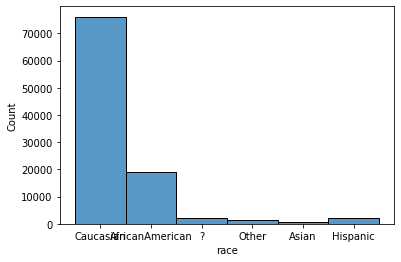

In [8]:
sns.histplot(data=df, x="race")

### Edad

Se observa que la mayor cantidad de la población en la muestra pertenece a los adultos mayores, es decir, el rango entre 50 y 90 años de edad.

<AxesSubplot:xlabel='age', ylabel='Count'>

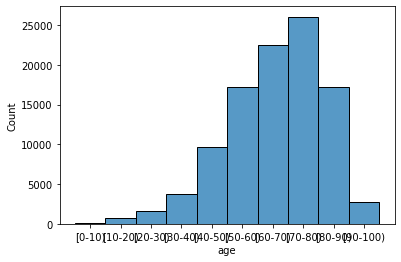

In [9]:
sns.histplot(data=df, x="age")

Se realiza una prueba de chi cuadrado y se observa que existe un diferencia entre el comportamiento de la variable readmisión con respecto a la edad del paciente.

1. crosstab:
readmitted   <30   >30     NO
age                          
[0-10)         3    26    132
[10-20)       40   224    427
[20-30)      236   510    911
[30-40)      424  1187   2164
[40-50)     1027  3278   5380
[50-60)     1668  5917   9671
[60-70)     2502  7897  12084
[70-80)     3069  9475  13524
[80-90)     2078  6223   8896
[90-100)     310   808   1675
2. chi squared: 313.17175286517806
3. p-value: 9.348415309480624e-56
4. degrees of freedom: 18


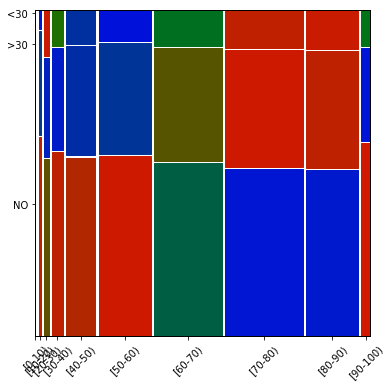

In [10]:
chi2_test(df, "age", "readmitted")

fig, _ = mosaic(df.sort_values('age'), ['age', "readmitted"], gap=0.01, statistic=True, labelizer=lambda k: '', label_rotation=[45,0])
fig.set_figheight(6)
fig.set_figwidth(6)
plt.show()

### Diagnósticos
Se integran las 3 columnas relacionadas con diagnósticos clínicos (principal y secundarios) y se obtiene los 10 diagnósticos de mayor aparición dentro del conjunto de datos.

In [11]:
diag = pd.concat([df["diag_1"], df["diag_2"], df["diag_3"]])
diag_pct = diag.value_counts(normalize=True) * 100
diag_pct.head(10)

428    5.928961
250    5.850349
276    4.525415
414    4.223742
401    4.052106
427    3.850991
599    2.235193
496    1.962017
403    1.864735
486    1.786779
dtype: float64

Se realiza la búsqueda de los códigos diagnósticos ICD9 (clasificación internacional de enfermedades) y se relacionó el top 10 con su respectiva descripción:
http://icd9.chrisendres.com/index.php?srchtype=diseases&srchtext=486&Submit=Search&action=search

* Insuficiencia cardiaca
* Diabetes mellitus
* Trastornos del equilibrio de líquidos, electrolitos y ácido-base
* Otras formas de cardiopatía isquémica crónica
* Hipertensión esencial
* Arritmias cardíacas
* Otros trastornos de la uretra y del tracto urinario.
* Obstrucción crónica de las vías respiratorias, no clasificada en otra parte
* Enfermedad renal crónica hipertensiva
* Neumonía, organismo no especificado

Se encuentra que dentro de los diagnósticos de los pacientes predominan enfermedades del corazón, hipertensión, y para este caso en específico enferemedades relacionadas con diabetes mellitus.

Es posible que otras comorbolidades puedan afectar el comportamiento de la enfermedad e incidan en la probabilidad de readmisión al centro hospitalario.

### Especialidad médica
Cerca del 50% de los datos tienen información faltante, y dentro de las categorías por las que son remitidos los pacientes son medicina interna, emergencias, práctica general y cardiología.

<AxesSubplot:>

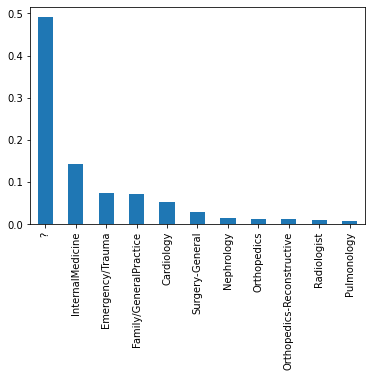

In [12]:
df["medical_specialty"].value_counts(normalize=True).head(11).plot(kind="bar")

### Prueba de hemoglobina glicosilada (HbA1c)

https://medlineplus.gov/spanish/a1c.html

El resultado de su prueba HbA1c se entrega en porcentajes. Mientras más alto sea el porcentaje, mayor es su nivel de azúcar en la sangre:

* Un nivel de HbA1c normal es menor al 5,7 por ciento
* La prediabetes se ubica entre 5,7 a 6,4 por ciento. Tener prediabetes es un factor de riesgo para desarrollar diabetes tipo 2. Las personas con prediabetes pueden necesitar repetir las pruebas cada año
* La diabetes tipo 2 se ubica por encima del 6,5 por ciento

Se analizan los resultados de las pruebas A1C y se observa que a la mayoría de los pacientes no se les aplico la prueba (84748), pero aquellos a los que si se realizó (Norm, >8 y >7) más del 50 % de los casos tuvo valores superiores a 8% que significa un indicador para diabetes tipo 2.

In [13]:
df["A1Cresult"].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

Se realiza un test de independencia entre las variables de resultado A1C y readmisión y se obtiene un valor de p-value bastante pequeño lo que nos indica que existe una relación entre las variables con un 95% de confianza.

Se observa que a los que no se les aplicó la prueba tuvieron un mayor porcentaje de readmisión temprana.

1. crosstab:
readmitted   <30    >30     NO
A1Cresult                     
>7           383   1300   2129
>8           811   2901   4504
None        9681  29745  45322
Norm         482   1599   2909
2. chi squared: 70.12429926076734
3. p-value: 3.855750642845673e-13
4. degrees of freedom: 6


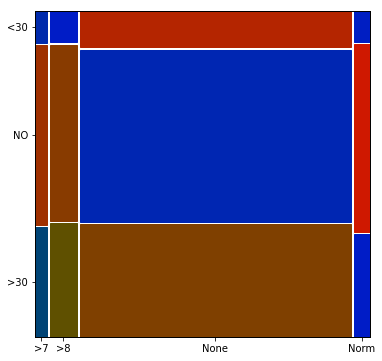

In [14]:
chi2_test(df, "A1Cresult", "readmitted")

fig, _ = mosaic(df.sort_values('A1Cresult'), ['A1Cresult', "readmitted"], gap=0.01, statistic=True, labelizer=lambda k: '')
fig.set_figheight(6)
fig.set_figwidth(6)
plt.show()

### Tiempo en el hospital (número de días)
Aunque no se observa una diferencia clara en el número de días entre las categorías de readmisión >30 Y <30 días, para los que no tuvieron readmisión si bien el rango intercuartilico es similar, si se observa una ligera diferencia entre la mediana de los datos. Las distribuciones son bastante similares y son asimétricas positivamente.

<AxesSubplot:xlabel='readmitted', ylabel='time_in_hospital'>

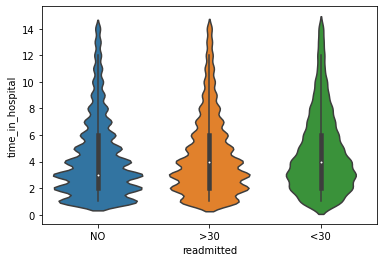

In [15]:
df_temp = df[["time_in_hospital", "readmitted"]].copy()
df_temp["log_time_in_hospital"] = np.log(df_temp["time_in_hospital"])

sns.violinplot(data=df_temp, x="readmitted", y="time_in_hospital")

### Número de visitas
En primer lugar se construye una nueva variable denominada como número de visitas que integra el número de vistias ambulatorias, hospitalarias y de emergencia que tuvo el paciente durante el año anterior, se espera que un paciente que ya tiene una historia amplia de visitas al hospital es posible que la probabilidad de readmisión también sea alta.

Se observa que la variable del número de visitas tienen una distribución con asimetría positiva, es decir la mayoría de los pacientes tuvieron 0 o muy pocas visitas y unos pocos pacientes tuvieron muchas visitas, y se hace necesario realizar una tranformación logarítmica.

<AxesSubplot:xlabel='readmitted', ylabel='log_number_visits'>

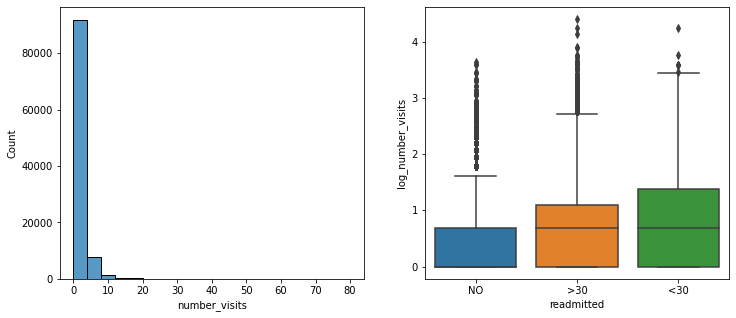

In [16]:
df_temp = df[["number_outpatient", "number_emergency", "number_inpatient", "readmitted"]].copy()
df_temp["number_visits"] = df_temp["number_outpatient"] + df_temp["number_emergency"] + df_temp["number_inpatient"]
df_temp["log_number_visits"] = np.log(df_temp["number_visits"] + 1)

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.histplot(data=df_temp, x="number_visits", bins=20, ax=ax[0])
sns.boxplot(data=df_temp, x="readmitted", y="log_number_visits", ax=ax[1])

Observamos el comportamiento de la variable transformada log_number_visits y se observa una diferencia entre las 3 categorías de readmisión con respecto al número de visitas de un paciente.

### Número de tratamientos
Se construye la variable número de tratamientos como la suma del número de procidimientos normales y de laboratorio, y el número de medicamentos usados durante la estadía del paciente.

Se realizan diagramas de cajas y bigotes para observar el comportamiento del número de tratamientos, y a primera medida no se observan diferencias claras en la variable de readmisión.

<AxesSubplot:xlabel='readmitted', ylabel='number_treatments'>

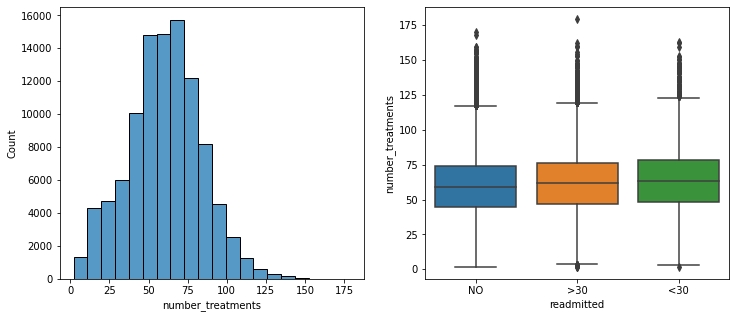

In [17]:
df_temp = df[["num_lab_procedures", "num_procedures", "num_medications", "readmitted", ]].copy()
df_temp["number_treatments"] = df_temp["num_lab_procedures"] + df_temp["num_procedures"] + df_temp["num_medications"]

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.histplot(data=df_temp, x="number_treatments", bins=20, ax=ax[0])
sns.boxplot(data=df_temp, x="readmitted", y="number_treatments", ax=ax[1])

### Número de diagnósticos

Se observa un comportamiento particular en la distribución en la que el número de diagnósticos tiene un pico en aproximadamente 9, y algunos pocos pacientes atípicos con valores superiores a 14. De igual manera no se observan diferencias entre las categorías de readmisión.

<AxesSubplot:xlabel='readmitted', ylabel='number_diagnoses'>

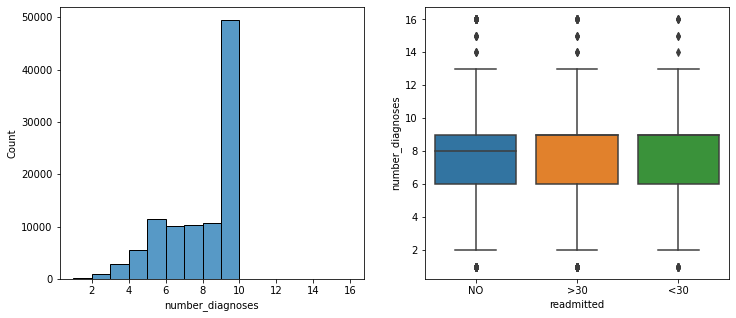

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.histplot(data=df, x="number_diagnoses", bins=15, ax=ax[0])
sns.boxplot(data=df, x="readmitted", y="number_diagnoses", ax=ax[1])

## Preparación de datos:

### Crear variables número de visitas y tratamientos:

In [19]:
df_final = df.copy()

df_final["number_visits"] = df_final["number_outpatient"] + df_final["number_emergency"] + df_final["number_inpatient"]
df_final["number_treatments"] = df_final["num_lab_procedures"] + df_final["num_procedures"] + df_final["num_medications"]

### Unir ids con su descripción
Se procede a reemplazar de la tabla principal las columnas admission_type_id, discharge_disposition_id y admission_source_id con su respectiva descripción

In [20]:
df_final = df_final.merge(df_id_adm_type, how="left", left_on='admission_type_id', right_on='admission_type_id')
df_final = df_final.merge(df_id_dis_disp, how="left", left_on='discharge_disposition_id', right_on='discharge_disposition_id')
df_final = df_final.merge(df_id_adm_sour, how="left", left_on='admission_source_id', right_on='admission_source_id')
df_final

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,number_visits,number_treatments,admission_type,discharge_disposition,admission_source
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,NO,0,42,Unknown,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,Ch,Yes,>30,0,77,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,Yes,NO,3,29,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,Ch,Yes,NO,0,61,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,Ch,Yes,NO,0,59,Emergency,Discharged to home,Emergency Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,No,Ch,Yes,>30,0,67,Emergency,Discharged/transferred to SNF,Emergency Room
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,No,No,Yes,NO,1,54,Emergency,Discharged/transferred to ICF,Transfer from a Skilled Nursing Facility (SNF)
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,No,Ch,Yes,NO,1,62,Emergency,Discharged to home,Emergency Room
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,No,Ch,Yes,NO,1,68,Urgent,Discharged/transferred to SNF,Emergency Room


### Diagnósticos (reducción)
Debido a la gran cantidad de diagnósticos presentes en el conjunto de datos, se toma la decisión de tomar solo los más importantes (aquellos con porcentaje de aparación superior al 1 por ciento de los casos) y todos los demás clasificarlos como otros, de esta manera, se reduce complejidad y dimensionalidad de los modelos resultantes.

Aproximadamente 23 diagnósticos recogen el 50% del total de pacientes.

In [21]:
diag = pd.concat([df["diag_1"], df["diag_2"], df["diag_3"]])
diag_pct = diag.value_counts(normalize=True) * 100

diag_pct_1 = diag_pct[diag_pct > 1]

print("Número total de diagnósticos:" ,diag_pct.size)
print("Número total de diagnósticos con al menos el 1% de casos:" ,diag_pct_1.size)
print("Porcentaje de diagnóstico superior a 1%:" ,sum(diag_pct_1))

Número total de diagnósticos: 916
Número total de diagnósticos con al menos el 1% de casos: 23
Porcentaje de diagnóstico superior a 1%: 53.249284305825775


Se crea una matriz de variables dummy para los 23 diagnósticos principales.

In [22]:
diag_id = pd.concat([
    df.rename(columns={"diag_1": "diag"})[["encounter_id", "diag"]],
    df.rename(columns={"diag_2": "diag"})[["encounter_id", "diag"]],
    df.rename(columns={"diag_3": "diag"})[["encounter_id", "diag"]]], axis=0)

diag_id["diag"] = diag_id["diag"].apply(lambda x: x if x in list(diag_pct_1.index) else "other")
diag_id["diag"] = "diag_" + diag_id["diag"]
diag_id["count"] = 1
diag_id = diag_id.pivot_table(values="count", index="encounter_id", columns="diag", fill_value=0).drop(columns="diag_other").reset_index()
diag_id

diag,encounter_id,diag_250,diag_250.02,diag_250.6,diag_276,diag_285,diag_401,diag_403,diag_410,diag_411,...,diag_491,diag_496,diag_518,diag_584,diag_585,diag_599,diag_682,diag_707,diag_780,diag_786
0,12522,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15738,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16680,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28236,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35754,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101762,443847782,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101763,443854148,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101764,443857166,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_final = df_final.merge(diag_id, how="left", on="encounter_id")
df_final

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_491,diag_496,diag_518,diag_584,diag_585,diag_599,diag_682,diag_707,diag_780,diag_786
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,0,0,0,0,0,0,0,0,0,0
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,0,0,0,0,0,0,0,0,0,0
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,0,0,0,0,0,0,0,0,0,0
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,0,0,0,0,0,0,0,0,0,0


### Variables de medicación (cambios):
Se agrupan todas las variables relacionados con cambios en la administración de medicamentos y se construyen 3 columnas nuevas con los conteos de disminución, aumento y suministro estable. Más la variable ya existente change que indica si hubo un cambio o no, sin importar la discriminación realizada con anterioridad.

In [24]:
variables_medication = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]
concat_series = []
for var in variables_medication:
    concat_series.append(df.rename(columns={var: "medi"})[["encounter_id", "medi"]])

medi_id = pd.concat(concat_series, axis=0)
medi_id["medi"] = "medi_" + medi_id["medi"]
medi_id["count"] = 1
medi_id = medi_id.pivot_table(values="count", index="encounter_id", columns="medi", fill_value=0, aggfunc=np.sum).drop(columns="medi_No").reset_index()

medi_id

medi,encounter_id,medi_Down,medi_Steady,medi_Up
0,12522,0,2,0
1,15738,0,2,0
2,16680,0,2,0
3,28236,0,1,0
4,35754,0,1,0
...,...,...,...,...
101761,443847548,1,1,0
101762,443847782,0,1,0
101763,443854148,1,1,0
101764,443857166,0,2,1


In [25]:
df_final = df_final.merge(medi_id, how="left", on="encounter_id")
df_final

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,diag_584,diag_585,diag_599,diag_682,diag_707,diag_780,diag_786,medi_Down,medi_Steady,medi_Up
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,0,0,0,0,0,0,0,0,0,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,0,0,0,0,0,0,0,0,0,1
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,0,0,0,0,0,0,0,1,1,0
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,0,0,0,0,0,0,0,0,1,0
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,0,0,0,0,0,0,0,1,1,0
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,0,0,0,0,0,0,0,0,2,1


### Especialidades más relevantes
Transformamos los datos para dejar únicamente las 10 especialidades más relevantes, las demás se clasifican como "otras".

In [26]:
spec_top = df_final["medical_specialty"].value_counts(normalize=True).head(10)

df_final["medical_specialty"] = df_final["medical_specialty"].apply(lambda x: "other" if x == "?" else x)
df_final["medical_specialty"] = df_final["medical_specialty"].apply(lambda x: x if x in list(spec_top.index) else "other")
df_final["medical_specialty"]

0                   other
1                   other
2                   other
3                   other
4                   other
               ...       
101761              other
101762              other
101763              other
101764    Surgery-General
101765              other
Name: medical_specialty, Length: 101766, dtype: object

### Eliminar variables redundantes:
Eliminamos identificadores, variables con baja varianza o con gran cantidad de valores nulos.

In [27]:
df_model = df_final.drop(
    columns=["patient_nbr", "encounter_id", "weight", "payer_code",
             "diag_1", "diag_2", "diag_3",
             "admission_type_id", "discharge_disposition_id", "admission_source_id",
             "number_outpatient", "number_emergency", "number_inpatient",
             "num_lab_procedures", "num_procedures", "num_medications"]
)

df_model = df_model.drop(columns=variables_medication)

"""df_model["log_time_in_hospital"] = np.log(df_model["time_in_hospital"])
df_model["log_number_visits"] = np.log(df_model["number_visits"] + 1)
df_model = df_model.drop(columns=["time_in_hospital", "number_visits"])"""
#df_model = df_model.drop(columns=["admission_type", "discharge_disposition", "admission_source", "medical_specialty"])

df_model

,race,gender,age,time_in_hospital,medical_specialty,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,...,diag_584,diag_585,diag_599,diag_682,diag_707,diag_780,diag_786,medi_Down,medi_Steady,medi_Up
0,Caucasian,Female,[0-10),1,other,1,None,None,No,No,...,0,0,0,0,0,0,0,0,0,0
1,Caucasian,Female,[10-20),3,other,9,None,None,Ch,Yes,...,0,0,0,0,0,0,0,0,0,1
2,AfricanAmerican,Female,[20-30),2,other,6,None,None,No,Yes,...,0,0,0,0,0,0,0,0,1,0
3,Caucasian,Male,[30-40),2,other,7,None,None,Ch,Yes,...,0,0,0,0,0,0,0,0,0,1
4,Caucasian,Male,[40-50),1,other,5,None,None,Ch,Yes,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),3,other,9,None,>8,Ch,Yes,...,0,0,0,0,0,0,0,1,1,0
101762,AfricanAmerican,Female,[80-90),5,other,9,None,None,No,Yes,...,0,0,0,0,0,0,0,0,1,0
101763,Caucasian,Male,[70-80),1,other,13,None,None,Ch,Yes,...,0,0,0,0,0,0,0,1,1,0
101764,Caucasian,Female,[80-90),10,Surgery-General,9,None,None,Ch,Yes,...,0,0,0,0,0,0,0,0,2,1


In [28]:
x = df_model.drop(columns="readmitted")
y = df_model[["readmitted"]]

x = pd.get_dummies(x, drop_first=True)
list(x.columns)

['time_in_hospital',
 'number_diagnoses',
 'number_visits',
 'number_treatments',
 'diag_250',
 'diag_250.02',
 'diag_250.6',
 'diag_276',
 'diag_285',
 'diag_401',
 'diag_403',
 'diag_410',
 'diag_411',
 'diag_414',
 'diag_427',
 'diag_428',
 'diag_486',
 'diag_491',
 'diag_496',
 'diag_518',
 'diag_584',
 'diag_585',
 'diag_599',
 'diag_682',
 'diag_707',
 'diag_780',
 'diag_786',
 'medi_Down',
 'medi_Steady',
 'medi_Up',
 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_Male',
 'gender_Unknown/Invalid',
 'age_[10-20)',
 'age_[20-30)',
 'age_[30-40)',
 'age_[40-50)',
 'age_[50-60)',
 'age_[60-70)',
 'age_[70-80)',
 'age_[80-90)',
 'age_[90-100)',
 'medical_specialty_Emergency/Trauma',
 'medical_specialty_Family/GeneralPractice',
 'medical_specialty_InternalMedicine',
 'medical_specialty_Nephrology',
 'medical_specialty_Orthopedics',
 'medical_specialty_Orthopedics-Reconstructive',
 'medical_specialty_Radiologist',
 'medical_specialty

## Modelamiento
En esta sección se procede a construir los modelos de clasificación.

Dividimos en primer lugar los datos entre entrenamiento y validación.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=123, stratify=y
)

Construimos un modelo de regresión logística con los datos de entrenamiento, debido a la gran cantidad de variables (dummies) y la alta dimensionalidad del conjunto de datos se utiliza regularización (por defecto Ridge o l2) que penaliza los coeficientes beta menos importantes hacia cero, y evita sobreajuste del modelo.

In [30]:
model_logit = LogisticRegression(random_state=0, max_iter=200)
#model_logit = LogisticRegression(random_state=35, max_iter=300, penalty="elasticnet", solver="saga", l1_ratio=0.1)
model_logit = model_logit.fit(x_train, y_train)

C:\Users\jmalaver\.conda\envs\ds4a\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\jmalaver\.conda\envs\ds4a\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Se evaluan exactitudes en entrenamieno y prueba:

In [31]:
print("Exactitud en set de entrenamiento:", model_logit.score(x_train, y_train))
print("Exactitud en set de prueba:", model_logit.score(x_test, y_test))

Exactitud en set de entrenamiento: 0.5790471110112865
Exactitud en set de prueba: 0.5740583033082214


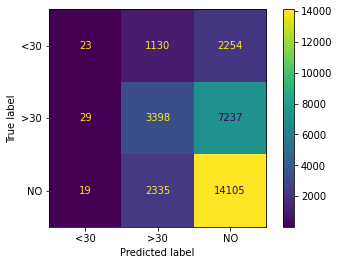

In [32]:
plot_confusion_matrix(model_logit, x_test, y_test)  
plt.show() 

Clase NO:
* Precisión: 0.59
* Exhaustividad: 0.85

Clase >30:
* Precisión: 0.49
* Exhaustividad: 0.31

Clase <30:
* Precisión: 0.32
* Exhaustividad: 0.006

Si bien las métricas de exactitud tanto en entrenamiento como en pruebas son cercanos al 0.57, lo que representa un desempeño moderado, el modelo sólo es capaz de predecir correctamente los casos que no tuvieron readmisión, con todos aquellos que si tuvieron readmisión, la capacidad predictiva es muy baja.

Se podría considerar probar balance de los datos, especialmente para la categoría <30 días, y revisar a mayor a profundidad el impacto de cada una de las variables en el modelo, si son o no significativas.